## Notebook for running single training and compare them

Imports and set seed optionally:

In [1]:
import torch
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor


from layer_insertion_loop import layer_insertion_loop
from train_and_test_ import train, check_testerror
from nets import feed_forward, two_weight_resnet, one_weight_resnet
from utils import ema

h=random.randint(0,100)
print(h)
random.seed(h)
np.random.seed(h)
torch.manual_seed(h)

torch.set_num_threads(8)

6


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Define and list hyperparameters:

In [3]:
no_hidden_layers_start = 1
fix_width = [50]
no_iters = 1
lr_decrease_after_li =1.0#0.8
epochs = [1,70]
wanted_testerror = 2.
_type = 'fwd'#'res2'
act_fun = nn.ReLU #nn.Tanh
interval_testerror = 1

batch_size = 20#60000 #1000 #20 #200 # 60000 for full batch
save_grad_norms = True

lr_init = 1e-1
optimizer_type = 'SGD'
lrscheduler_type = 'StepLR'
lrscheduler_args = {'step_size': 400,
                    'gamma': 0.1}


# for classical 
epochs_classical = sum(epochs)
lr_init_classical = lr_init
lrscheduler_args_classical = {'step_size': 400,
                    'gamma': 0.1}

Load dataset:

In [4]:
MNIST = True
FMNIST = False
CIFAR10 = False

In [5]:
if MNIST:    
    # Download training data from open datasets.
    training_data = datasets.MNIST(
        root="data",
        train=True,
        download=True,
        transform=ToTensor(),
    )

    # Download test data from open datasets.
    test_data = datasets.MNIST(
        root="data",
        train=False,
        download=True,
        transform=ToTensor(),
    )

    tr_split_len = 60000#10000
    te_split_len = 10000#int(0.33*tr_split_len)
    training_data = torch.utils.data.random_split(training_data, [tr_split_len, len(training_data)-tr_split_len])[0]
    test_data = torch.utils.data.random_split(test_data, [te_split_len, len(test_data)-te_split_len])[0]

if FMNIST:
    # Download training data from open datasets.
    training_data = datasets.FashionMNIST(
        root="data",
        train=True,
        download=True,
        transform=ToTensor(),
    )

    # Download test data from open datasets.
    test_data = datasets.FashionMNIST(
        root="data",
        train=False,
        download=True,
        transform=ToTensor(),
    )

if CIFAR10:
    # Download training data from open datasets.
    training_data = datasets.CIFAR10(
        root="data",
        train=True,
        download=True,
        transform=ToTensor(),
    )

    # Download test data from open datasets.
    test_data = datasets.CIFAR10(
        root="data",
        train=False,
        download=True,
        transform=ToTensor(),
    )

In [6]:
print('no of iterations in one epoch:',int(len(training_data)/batch_size))
print(len(training_data))
print(len(test_data))

no of iterations in one epoch: 3000
60000
10000


Create dataloader:

In [7]:
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=10000)

Build models:

In [8]:
kwargs_net ={
        'hidden_layers': no_hidden_layers_start,
        'dim_hidden_layers': fix_width,
        'act_fun': act_fun,
        'type': _type
}

dim_in = 28*28 #32*32 
dim_out = 10

In [9]:
# classical net
kwargs_net_classical = {
    'hidden_layers': no_hidden_layers_start,
    'dim_hidden_layers': fix_width,
    'act_fun': act_fun,
    'type': _type
}

Determine which trainings are run:

In [10]:
T1 = True
T2 = True
T3 = True

In [11]:
if False:
    its, data = next(enumerate(train_dataloader))
    #print(labels[0])
    images = data[0]
    for i in range(1):
        plt.imshow(images[i].reshape(28,28), cmap="gray")
        plt.show()

In [12]:
for X,y in test_dataloader:
    print(X.shape)
    print(y.shape)
    print(y)

torch.Size([10000, 1, 28, 28])
torch.Size([10000])
tensor([4, 7, 2,  ..., 8, 2, 7])


## Training with layer insertion:

In [13]:
# build model
if _type=='fwd':
    model_init = feed_forward(dim_in, dim_out,**kwargs_net)
if _type=='res2':
    model_init = two_weight_resnet(dim_in, dim_out,**kwargs_net)
if _type=='res1':
    model_init = one_weight_resnet(dim_in, dim_out,**kwargs_net)

param_init = torch.nn.utils.parameters_to_vector(model_init.parameters())
param_init = copy.deepcopy(param_init.data)
param_init_class = copy.deepcopy(param_init.data)

Check initial test error of the model

In [14]:
print(check_testerror(test_dataloader,model_init))
initial_train_acc = check_testerror(train_dataloader,model_init)
print(check_testerror(train_dataloader,model_init))

87.34
87.68833333333333


In [15]:
# train ali 1
if T1:
    model1, mb_losses1, test_errors_short1, test_errors1, exit_flag1, grad_norms1 = layer_insertion_loop(
        iters=no_iters,
        epochs=epochs,
        model= model_init,
        kwargs_net=kwargs_net,
        dim_in=dim_in,
        dim_out=dim_out,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        lr_init=lr_init,
        wanted_test_error=wanted_testerror,
        mode='abs max',
        optimizer_type=optimizer_type,
        lrschedule_type=lrscheduler_type,
        lrscheduler_args=lrscheduler_args,
        check_testerror_between=interval_testerror,
        decrease_after_li=lr_decrease_after_li,
        print_param_flag=False,
        start_with_backtracking=None,
        v2=False,
        save_grad_norms=save_grad_norms,
        use_adaptive_lr=True
    ) 

starting on 1. net !
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=50, bias=True)
  (2): ReLU()
  (3): Linear(in_features=50, out_features=10, bias=True)
)
mbloss:  2.3090829849243164
(dataset)error at epoch 0 is 4.790000000000006
Test error after first step of loop 1 is 4.790000000000006!
the averaged shadow prices  of all available positions: [tensor(0.0003)]
Insert layer at position 0 !
[tensor(14.2945)]
[tensor(14.2945), tensor(1.3394)]
[tensor(14.2945), tensor(1.3394), tensor(7.0711)]
[tensor(14.2945), tensor(1.3394), tensor(7.0711), tensor(0.)]
[tensor(14.2945), tensor(1.3394), tensor(7.0711), tensor(0.), tensor(8.6223)]
[tensor(14.2945), tensor(1.3394), tensor(7.0711), tensor(0.), tensor(8.6223), tensor(0.5685)]
starting on 2. net!
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=50, bias=True)
  (2): ReLU()
  (3): Linear(in_features=50, out_features=50, bias=True)
  (4): ReLU()
  (5

In [ ]:
print('test error: ',check_testerror(test_dataloader, model1))
train_acc = check_testerror(train_dataloader, model1)
print('train error: ',train_acc)

test error:  2.549999999999997
train error:  0.471666666666664


plot results:

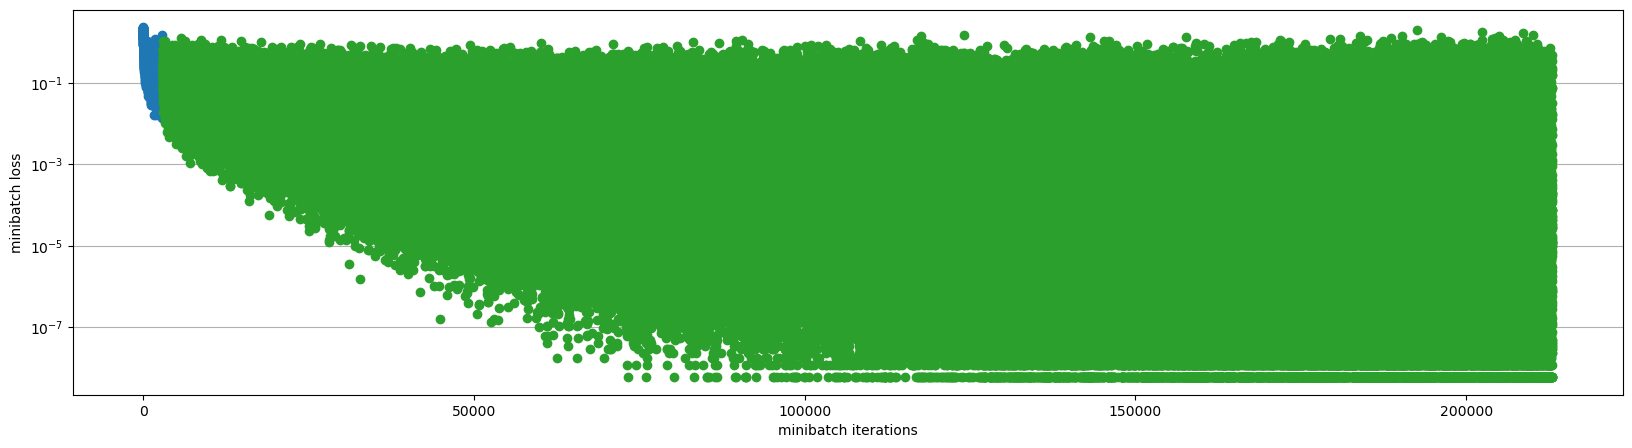

In [ ]:
end_list=[]
for i,e in enumerate(epochs):
    end_list.append(int(e*len(training_data)/batch_size))
    end_list.append(1) 
end_list.pop() # removes last 1 which was too much

# todo plot
if T1:
    plt.figure(figsize=(20,5))
    plt.grid(which='major', axis='x', zorder=-1.0)
    xfull = range(1,len(mb_losses1)+1)
    yfull = mb_losses1
    begin=0
    end=0
    for i in range(len(end_list)):
        end=end+end_list[i]
        x_curr= xfull[begin:end]
        y_curr= yfull[begin:end]
        begin=end
        plt.plot(x_curr,y_curr,'o')
    plt.xlabel('minibatch iterations')
    plt.ylabel('minibatch loss')

    plt.yscale('log')
    #plt.ylim((0.4,.6))
    #plt.xlim((99300,99800))
    
    plt.grid()
    plt.plot(np.zeros(len(mb_losses1)))

In [ ]:
#print(len(grad_norms1[1]))

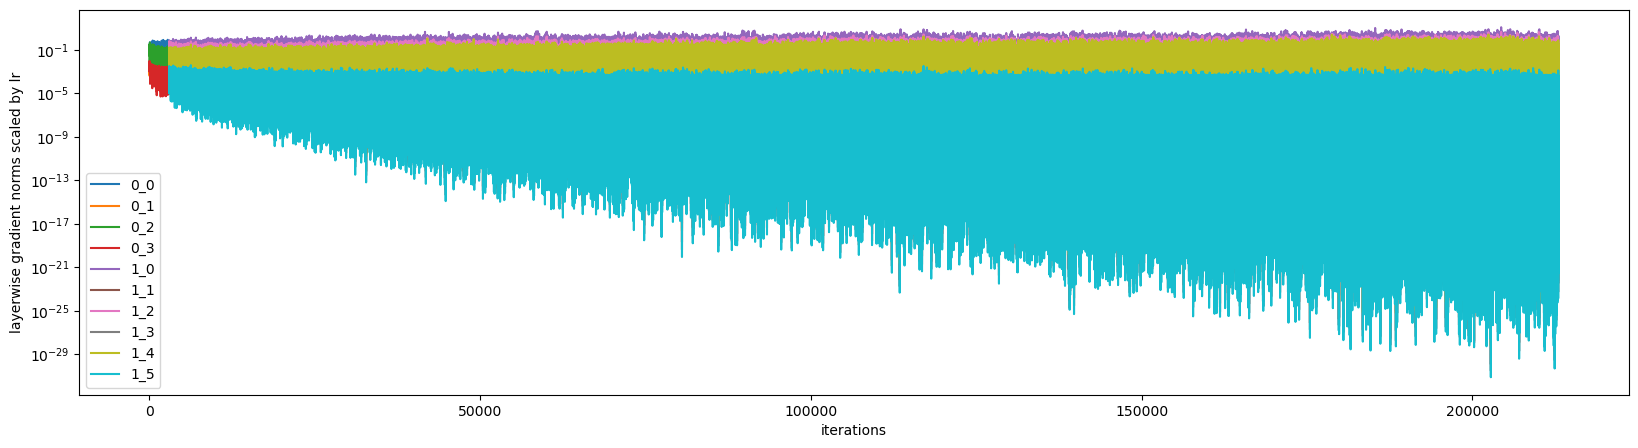

In [ ]:
if True:
    plt.figure(figsize=(20,5))
    l1 = len(grad_norms1[0])
    l2 = len(grad_norms1[1])
    len_t1 = len(grad_norms1[0][0])
    len_t2 = len(grad_norms1[1][0])
    for i in range(l1):
        plt.plot(grad_norms1[0][i], label=f'0_{i}')
    for j in range(l2):
        #print(list(range(len_t1,len_t2+len_t1)))
        plt.plot(list(range(len_t1,len_t2+len_t1)), grad_norms1[1][j], label=f'1_{j}')
    plt.legend()
    plt.yscale('log')
    plt.xlabel('iterations')
    plt.ylabel('layerwise gradient norms scaled by lr')

In [ ]:
# todo plot
if False:
    plt.figure(figsize=(20,5))
    plt.grid(which='major', axis='x', zorder=-1.0)
    xfull = range(1,len(grad_norms1)+1)
    yfull = grad_norms1
    begin=0
    end=0
    for i in range(len(end_list)):
        end=end+end_list[i]
        x_curr= xfull[begin:end]
        y_curr= yfull[begin:end]
        begin=end
        plt.plot(x_curr,y_curr,'o')
    plt.xlabel('minibatch iterations')
    plt.ylabel('squared grad norm')

    plt.yscale('log')
    #plt.ylim((0.4,.6))
    #plt.xlim((99300,99800))
    
    plt.grid()
    plt.plot(np.zeros(len(grad_norms1)))

Text(0.5, 0, 'epochs')

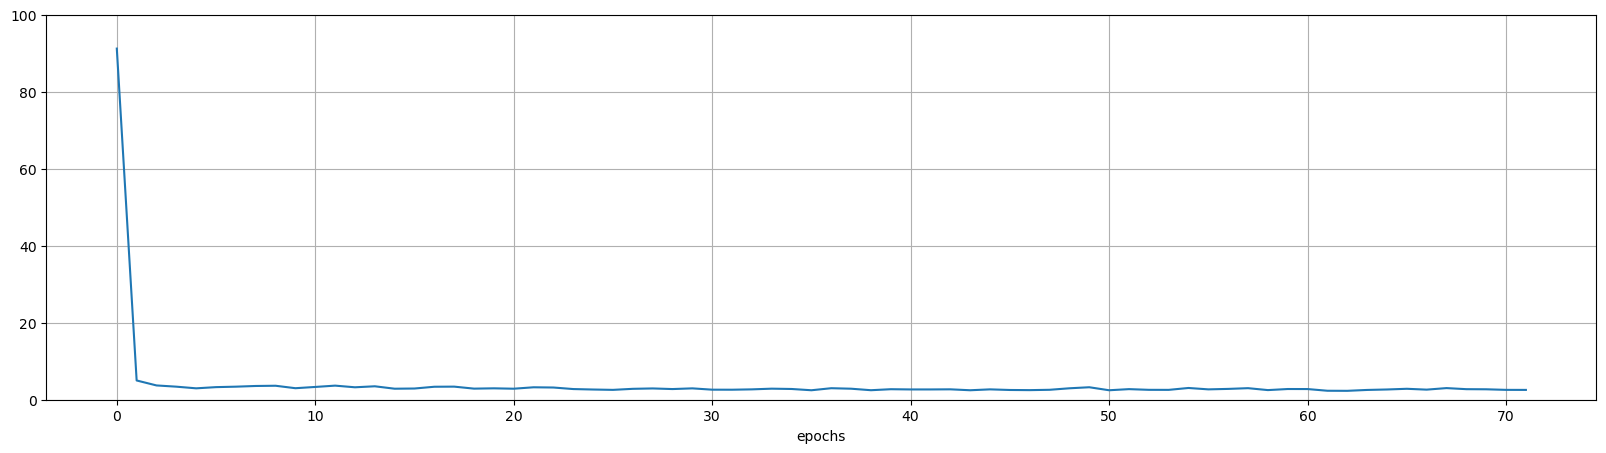

In [ ]:
plt.figure(figsize=(20,5))
plt.plot([initial_train_acc]+test_errors1)#,'o')
plt.ylim(top=100,bottom=0)
plt.grid()
plt.xlabel('epochs')

## Second training

In [ ]:
# build net
if _type=='fwd':
    model_init2 = feed_forward(dim_in, dim_out,**kwargs_net)
if _type=='res2':
    model_init2 = two_weight_resnet(dim_in, dim_out,**kwargs_net)
if _type=='res1':
    model_init2 = one_weight_resnet(dim_in, dim_out,**kwargs_net)

torch.nn.utils.vector_to_parameters(param_init, model_init2.parameters())

In [ ]:
print(check_testerror(test_dataloader,model_init2))
initial_train_acc2 = check_testerror(train_dataloader,model_init2)
print(check_testerror(train_dataloader,model_init2))

91.4
91.205


In [ ]:
if T2:
    model2, mb_losses2, test_errors_short2, test_errors2, exit_flag2, grad_norms2 = layer_insertion_loop(
        iters=no_iters,
        epochs=epochs,
        model= model_init2,
        kwargs_net=kwargs_net,
        dim_in=dim_in,
        dim_out=dim_out,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        lr_init=lr_init,
        wanted_test_error=wanted_testerror,
        mode='abs min',#'threshold',
        optimizer_type=optimizer_type,
        lrschedule_type=lrscheduler_type,
        lrscheduler_args=lrscheduler_args,
        check_testerror_between=interval_testerror,
        decrease_after_li=lr_decrease_after_li,
        print_param_flag=False,
        start_with_backtracking=None,
        v2=False,
        save_grad_norms=save_grad_norms
    ) 

starting on 1. net !
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=50, bias=True)
  (2): ReLU()
  (3): Linear(in_features=50, out_features=10, bias=True)
)
mbloss:  2.2864480018615723
(dataset)error at epoch 0 is 5.0
Test error after first step of loop 1 is 5.0!
the averaged shadow prices  of all available positions: [tensor(0.0003)]
Insert layer at position 0 !
[tensor(9.7104)]
[tensor(9.7104), tensor(0.9211)]
[tensor(9.7104), tensor(0.9211), tensor(7.0711)]
[tensor(9.7104), tensor(0.9211), tensor(7.0711), tensor(0.)]
[tensor(9.7104), tensor(0.9211), tensor(7.0711), tensor(0.), tensor(7.3811)]
[tensor(9.7104), tensor(0.9211), tensor(7.0711), tensor(0.), tensor(7.3811), tensor(0.7274)]
starting on 2. net!
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=50, bias=True)
  (2): ReLU()
  (3): Linear(in_features=50, out_features=50, bias=True)
  (4): ReLU()
  (5): Linear(in_features=50, out_feat

In [ ]:
if T2:
    print('test error: ',check_testerror(test_dataloader, model2))
    print('train error: ',check_testerror(train_dataloader, model2))

test error:  2.549999999999997
train error:  0.471666666666664


plot results:

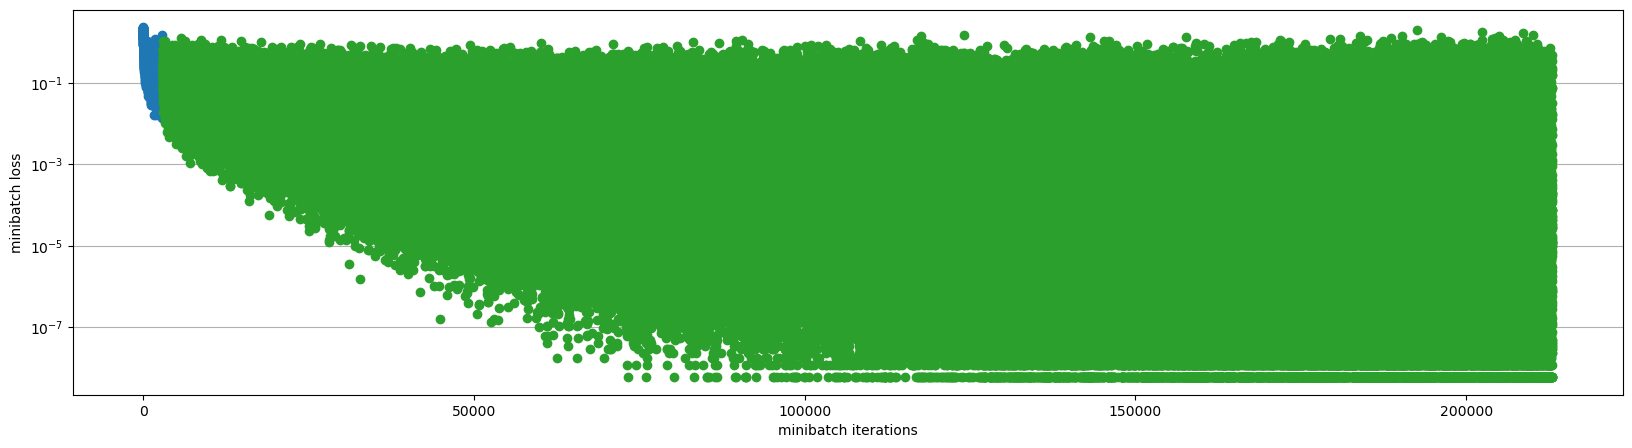

In [ ]:
# todo plot
if T2:
    plt.figure(figsize=(20,5))
    plt.grid(which='major', axis='x', zorder=-1.0)
    xfull = range(1,len(mb_losses2)+1)
    yfull = mb_losses2
    begin=0
    end=0
    for i in range(len(end_list)):
        end=end+end_list[i]
        x_curr= xfull[begin:end]
        y_curr= yfull[begin:end]
        begin=end
        plt.plot(x_curr,y_curr,'o')
    plt.xlabel('minibatch iterations')
    plt.ylabel('minibatch loss')

    plt.yscale('log')
    #plt.ylim((0.4,.6))
    #plt.xlim((99300,99800))
    
    plt.grid()
    plt.plot(np.zeros(len(mb_losses2)))

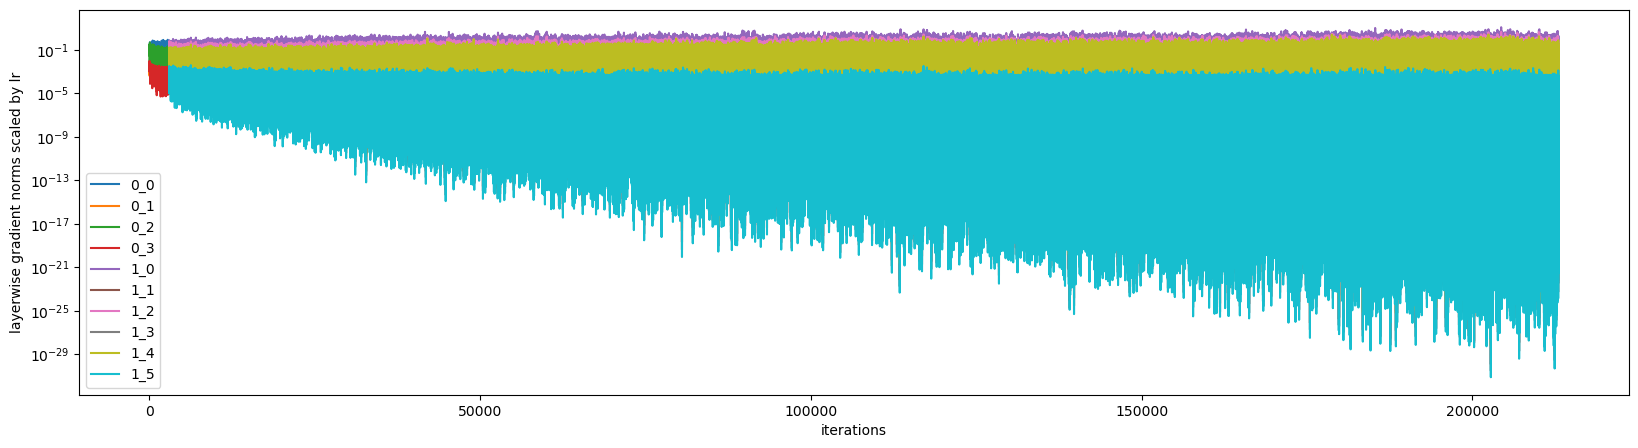

In [ ]:
if True and T2:
    plt.figure(figsize=(20,5))
    l1 = len(grad_norms2[0])
    l2 = len(grad_norms2[1])
    len_t1 = len(grad_norms2[0][0])
    len_t2 = len(grad_norms2[1][0])
    for i in range(l1):
        plt.plot(grad_norms2[0][i], label=f'0_{i}')
    for j in range(l2):
        #print(list(range(len_t1,len_t2+len_t1)))
        plt.plot(list(range(len_t1,len_t2+len_t1)), grad_norms2[1][j], label=f'1_{j}')
    plt.legend()
    plt.yscale('log')
    plt.xlabel('iterations')
    plt.ylabel('layerwise gradient norms scaled by lr')

In [ ]:
# todo plot
if False:
    plt.figure(figsize=(20,5))
    plt.grid(which='major', axis='x', zorder=-1.0)
    xfull = range(1,len(grad_norms2)+1)
    yfull = grad_norms2
    begin=0
    end=0
    for i in range(len(end_list)):
        end=end+end_list[i]
        x_curr= xfull[begin:end]
        y_curr= yfull[begin:end]
        begin=end
        plt.plot(x_curr,y_curr,'o')
    plt.xlabel('minibatch iterations')
    plt.ylabel('squared grad norm')

    plt.yscale('log')
    #plt.ylim((0.4,.6))
    #plt.xlim((99300,99800))
    
    plt.grid()
    plt.plot(np.zeros(len(grad_norms2)))

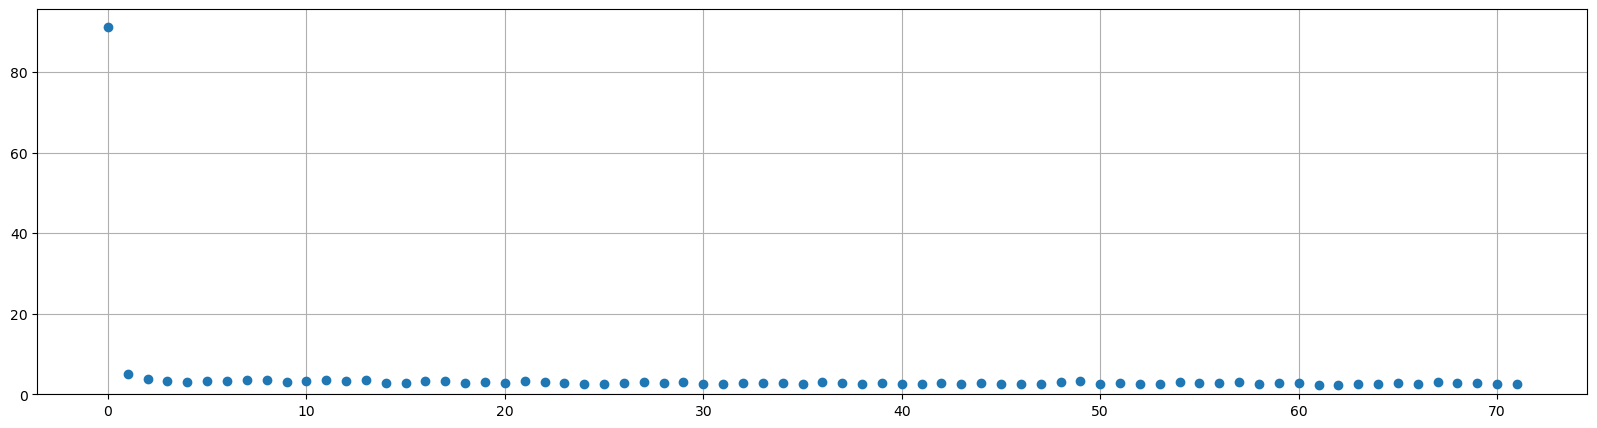

In [ ]:
if T2:
    plt.figure(figsize=(20,5))
    #plt.ylim((0,100))
    plt.plot([initial_train_acc2]+test_errors2,'o')
    plt.ylim(bottom=0)
    plt.grid()

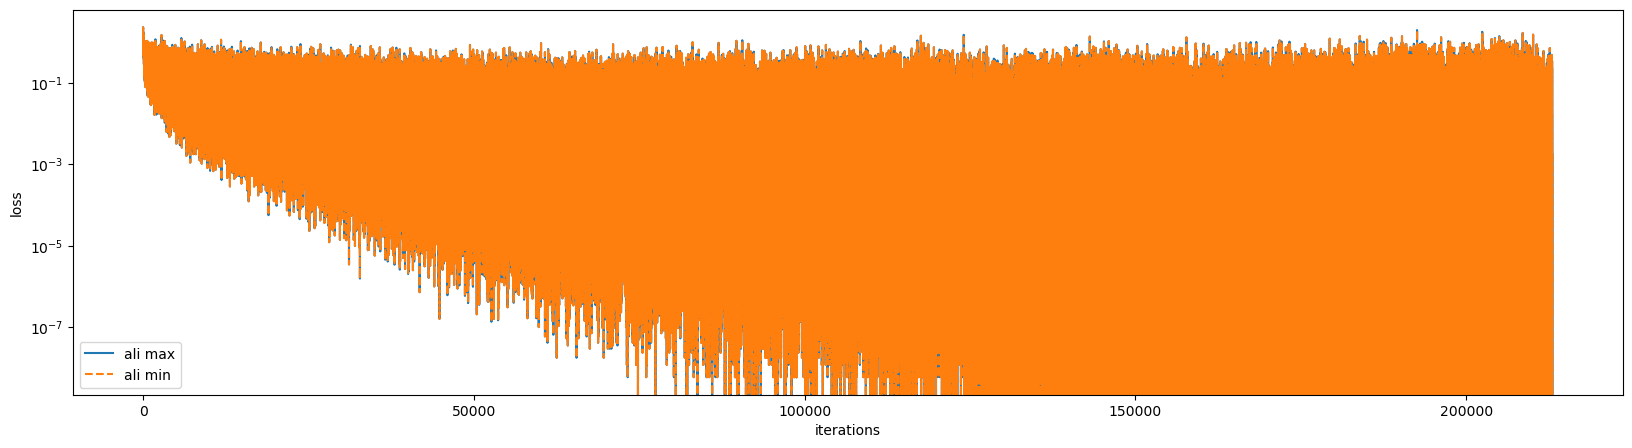

In [ ]:
plt.figure(figsize=(20,5))

plt.plot(mb_losses1,label='ali max')
if T2:
    plt.plot(mb_losses2, '--',label='ali min')
plt.xlabel('iterations')
plt.ylabel('loss')

plt.yscale('log')

plt.legend()
#plt.ylim((1e-8,1.1))
#plt.xlim((80,100))
plt.show()

## Third training

In [ ]:
# build model
if _type=='fwd':
    model_classical = feed_forward(dim_in, dim_out,**kwargs_net_classical)
if _type=='res2':
    model_classical = two_weight_resnet(dim_in, dim_out,**kwargs_net_classical)
if _type=='res1':
    model_classical = one_weight_resnet(dim_in, dim_out,**kwargs_net_classical)

torch.nn.utils.vector_to_parameters(param_init_class,model_classical.parameters())

In [ ]:
print('test error: ',check_testerror(test_dataloader, model_classical))
print('train error: ',check_testerror(train_dataloader, model_classical))
initial_train_acc_class = check_testerror(train_dataloader, model_classical)

test error:  91.4
train error:  91.205


In [ ]:
# build optimizer
if optimizer_type == 'SGD':
    optimizer_classical = torch.optim.SGD(model_classical.parameters(), lr_init_classical)
if optimizer_type == 'Adam':
    optimizer_classical = torch.optim.Adam(model_classical.parameters(), lr_init_classical)

# build lr scheduler
if lrscheduler_type == 'StepLR':
    step_size = lrscheduler_args_classical['step_size']
    gamma = lrscheduler_args_classical['gamma']
    lrscheduler_classical = torch.optim.lr_scheduler.StepLR(
            optimizer_classical, step_size=step_size, gamma=gamma)


In [ ]:
if T3:
    print('training classically on model', model_classical)
    mblosses_classical, lr_end, test_error_classical, exit_flag_classical, grad_norms_classical = train(model_classical,
                                                             train_dataloader=train_dataloader,
                                                             epochs=epochs_classical,
                                                             optimizer=optimizer_classical,
                                                             scheduler=lrscheduler_classical,
                                                             wanted_testerror=wanted_testerror,
                                                             start_with_backtracking=None,
                                                             check_testerror_between=interval_testerror,
                                                             test_dataloader=test_dataloader,
                                                             print_param_flag=False,
                                                             save_grad_norms=save_grad_norms
                                                             )

training classically on model Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=50, bias=True)
  (2): ReLU()
  (3): Linear(in_features=50, out_features=10, bias=True)
)
mbloss:  2.2864480018615723
(dataset)error at epoch 0 is 5.0
mbloss:  0.2775366008281708
(dataset)error at epoch 1 is 3.9799999999999898
mbloss:  0.16743573546409607
(dataset)error at epoch 2 is 3.3299999999999983
mbloss:  0.15577451884746552
(dataset)error at epoch 3 is 2.9399999999999977
mbloss:  0.12724962830543518
(dataset)error at epoch 4 is 2.819999999999993
mbloss:  0.12011925876140594
(dataset)error at epoch 5 is 2.9099999999999966
mbloss:  0.09563521295785904
(dataset)error at epoch 6 is 2.8900000000000006
mbloss:  0.07333044707775116
(dataset)error at epoch 7 is 2.9399999999999977
mbloss:  0.05982154607772827
(dataset)error at epoch 8 is 2.75
mbloss:  0.04432122781872749
(dataset)error at epoch 9 is 2.9200000000000017
mbloss:  0.043249137699604034
(dataset)error at

plot results:

In [ ]:
if T3:
    print('test error: ',check_testerror(test_dataloader, model_classical))
    print('train error: ',check_testerror(train_dataloader, model_classical))

test error:  2.4299999999999926
train error:  0.0


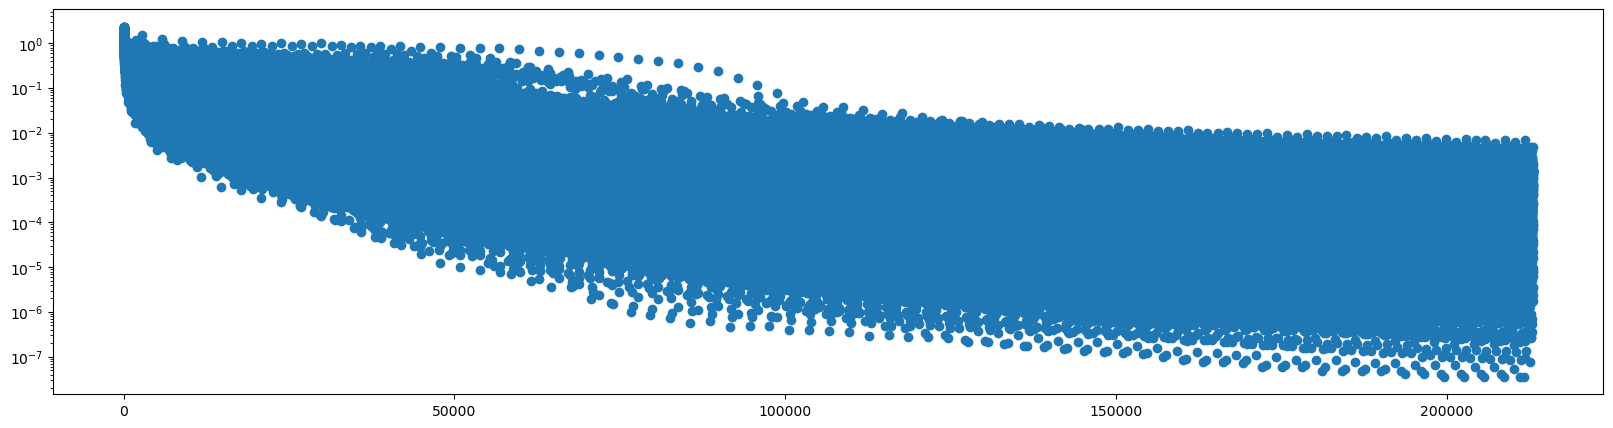

In [ ]:
if T3:
    plt.figure(figsize=(20,5))
    plt.plot(mblosses_classical,'o')
    plt.yscale('log')
    
    #plt.xlim((-10,3000))
    #plt.ylim((0.68,0.8))

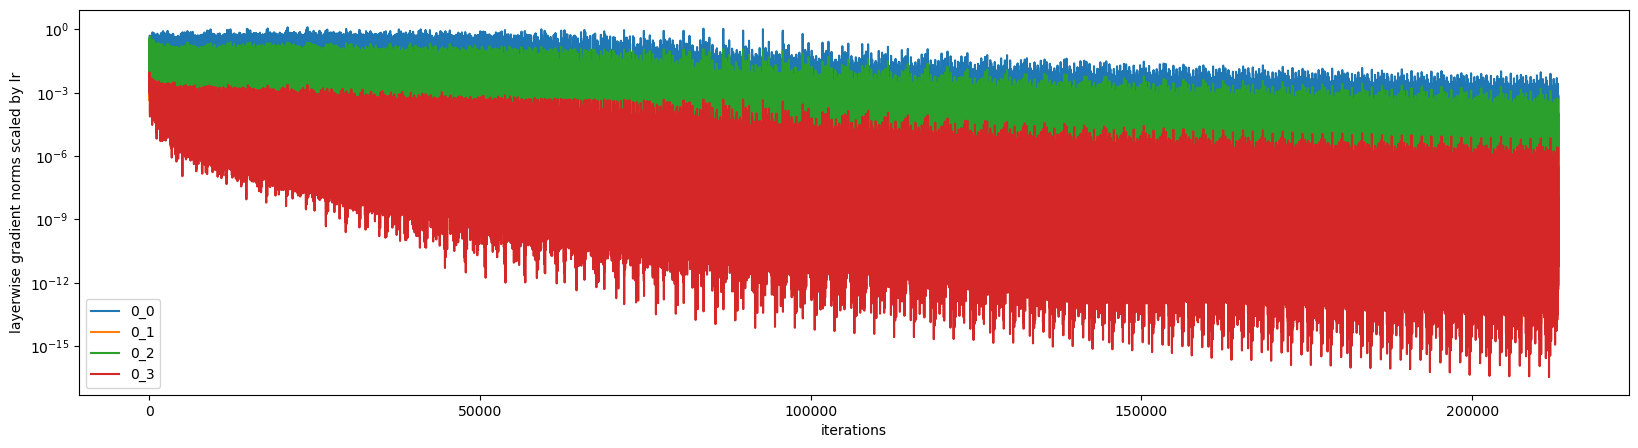

In [ ]:
if True:
    plt.figure(figsize=(20,5))
    l1 = len(grad_norms_classical)
    for i in range(l1):
        plt.plot(grad_norms_classical[i], label=f'0_{i}')
    plt.legend()
    plt.yscale('log')
    plt.xlabel('iterations')
    plt.ylabel('layerwise gradient norms scaled by lr')

In [ ]:
if False:
    plt.figure(figsize=(20,5))
    plt.plot(grad_norms_classical,'o')
    plt.yscale('log')

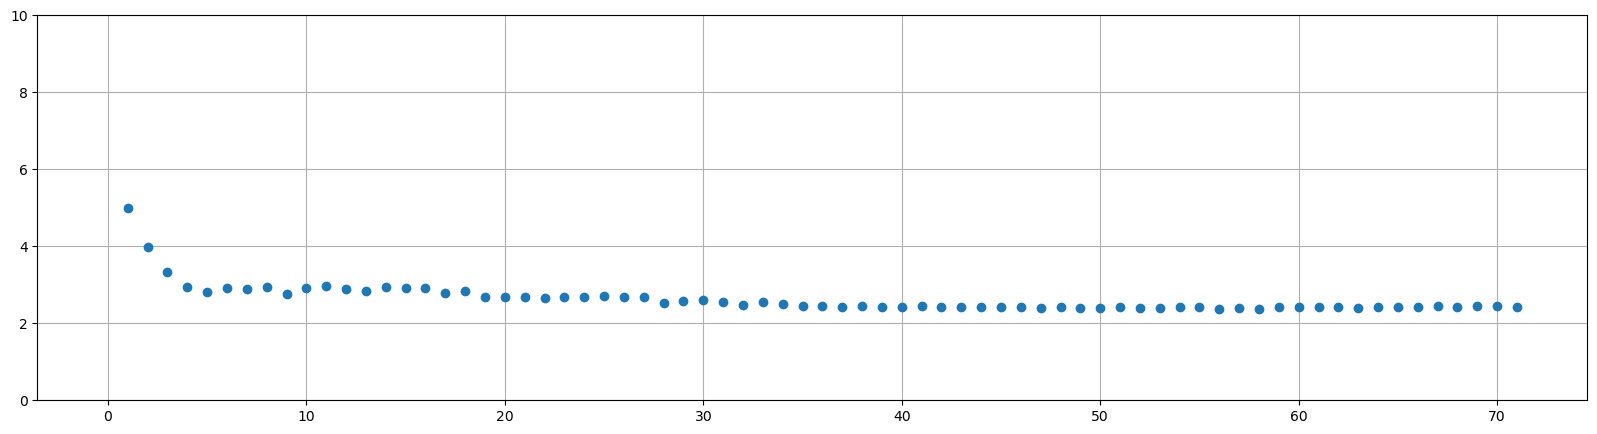

In [ ]:
if T3:
    plt.figure(figsize=(20,5))
    plt.plot([initial_train_acc_class]+test_error_classical,'o')
    plt.ylim(bottom=0,top=10)
    plt.grid()

## Comparison of the trainings as plot:


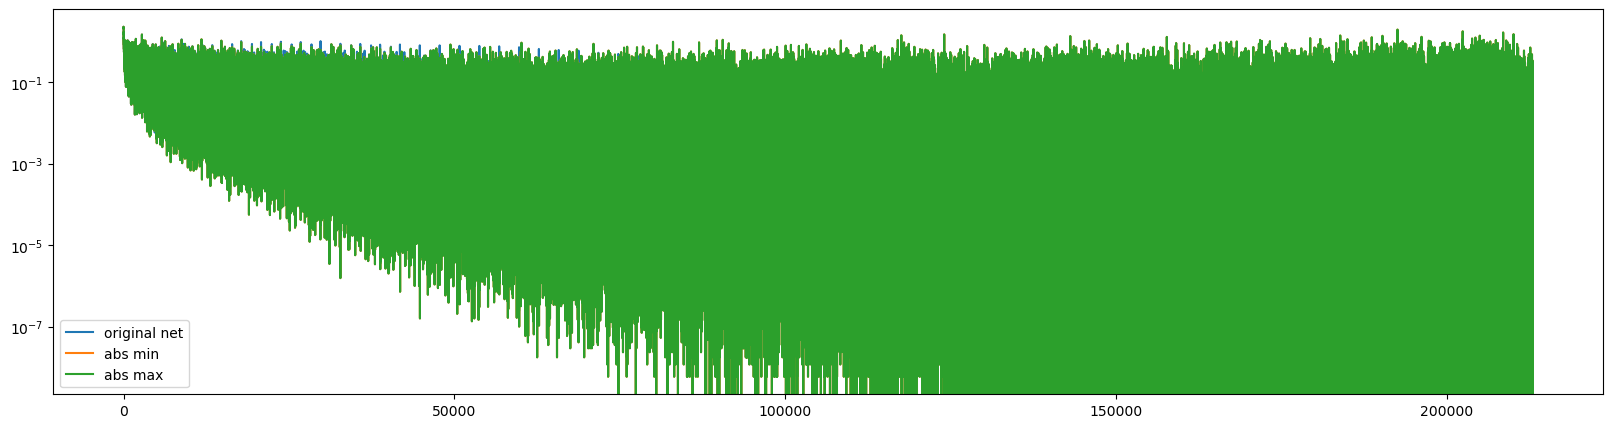

In [ ]:
plt.figure(figsize=(20,5))

#if T2:
#    plt.plot(np.zeros(max(len(mb_losses1),len(mb_losses2))))#,len(mblosses_classical))))
if T3:
    plt.plot(mblosses_classical, label='original net')
if T2:
    plt.plot(mb_losses2, label='abs min')
plt.plot(mb_losses1,label='abs max')

plt.yscale('log')

plt.legend()
#plt.ylim((1e-8,1.1))
#plt.xlim((80,100))
plt.show()

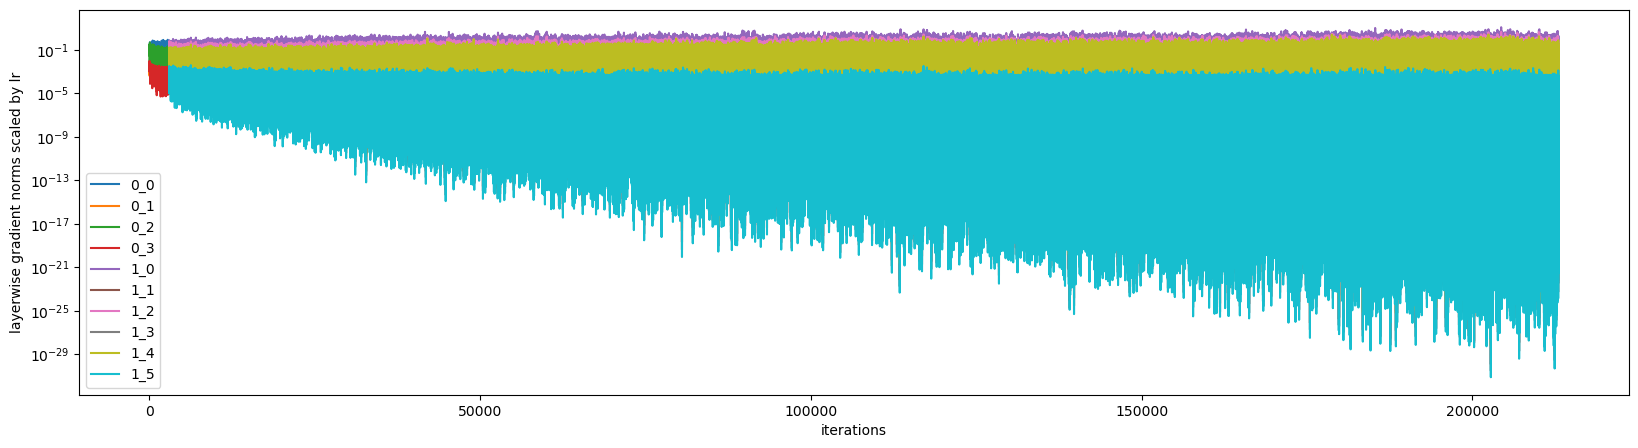

In [ ]:
# li
if True:
    plt.figure(figsize=(20,5))
    l1 = len(grad_norms1[0])
    l2 = len(grad_norms1[1])
    len_t1 = len(grad_norms1[0][0])
    len_t2 = len(grad_norms1[1][0])
    for i in range(l1):
        plt.plot(grad_norms1[0][i], label=f'0_{i}')
    for j in range(l2):
        #print(list(range(len_t1,len_t2+len_t1)))
        plt.plot(list(range(len_t1,len_t2+len_t1)), grad_norms1[1][j], label=f'1_{j}')
    plt.legend()
    plt.yscale('log')
    plt.xlabel('iterations')
    plt.ylabel('layerwise gradient norms scaled by lr')

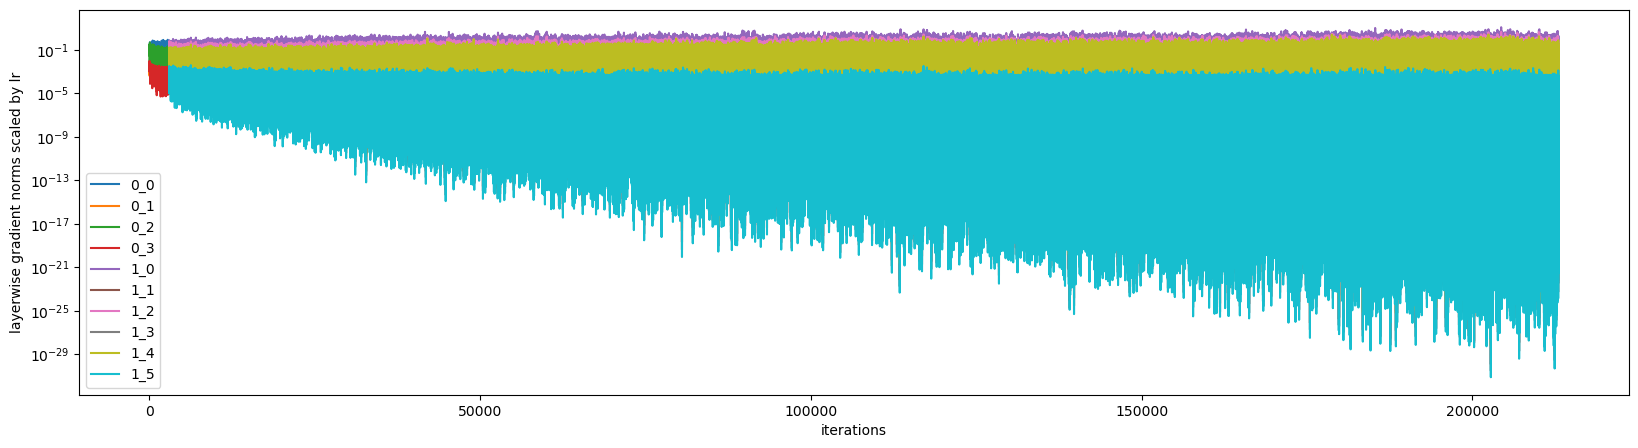

In [ ]:
if True and T2:
    plt.figure(figsize=(20,5))
    l1 = len(grad_norms2[0])
    l2 = len(grad_norms2[1])
    len_t1 = len(grad_norms2[0][0])
    len_t2 = len(grad_norms2[1][0])
    for i in range(l1):
        plt.plot(grad_norms2[0][i], label=f'0_{i}')
    for j in range(l2):
        #print(list(range(len_t1,len_t2+len_t1)))
        plt.plot(list(range(len_t1,len_t2+len_t1)), grad_norms2[1][j], label=f'1_{j}')
    plt.legend()
    plt.yscale('log')
    plt.xlabel('iterations')
    plt.ylabel('layerwise gradient norms scaled by lr')

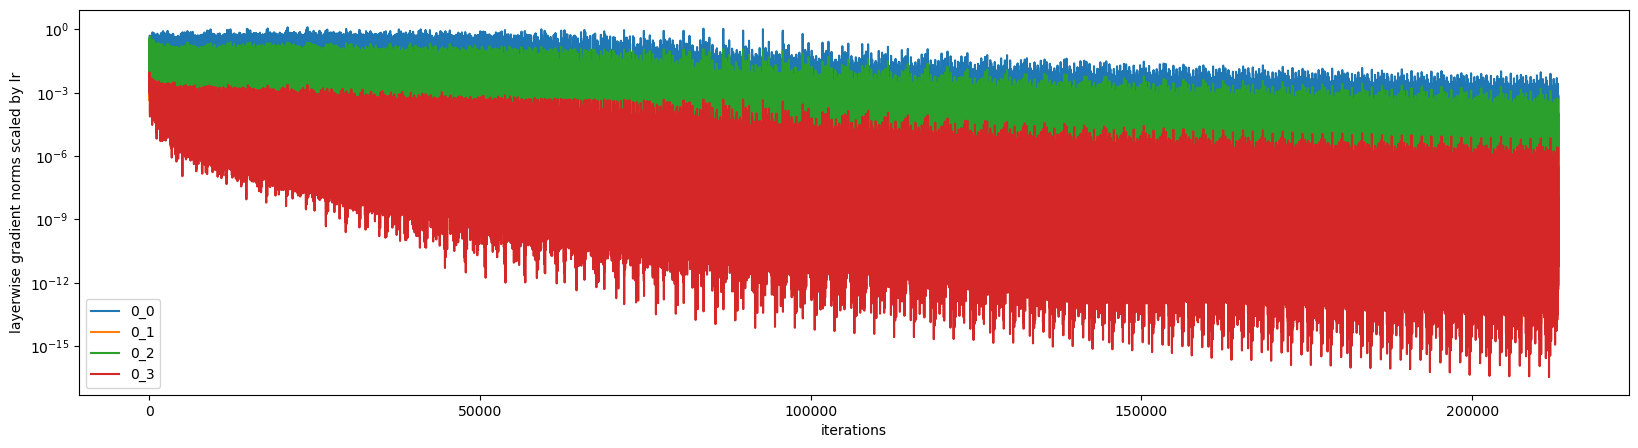

In [ ]:
# classical
if True:
    plt.figure(figsize=(20,5))
    l1 = len(grad_norms_classical)
    for i in range(l1):
        plt.plot(grad_norms_classical[i], label=f'0_{i}')
    plt.legend()
    plt.yscale('log')
    plt.xlabel('iterations')
    plt.ylabel('layerwise gradient norms scaled by lr')

In [ ]:
from utils import ema2

In [ ]:
smooth_factor = 0.
s1= ema2(mb_losses1, smooth_factor,no_of_steps_back=1000)
if T2:
    s2= ema2(mb_losses2, smooth_factor, no_of_steps_back=1000)
if T3:
    s3 = ema2(mblosses_classical, smooth_factor, no_of_steps_back=1000)

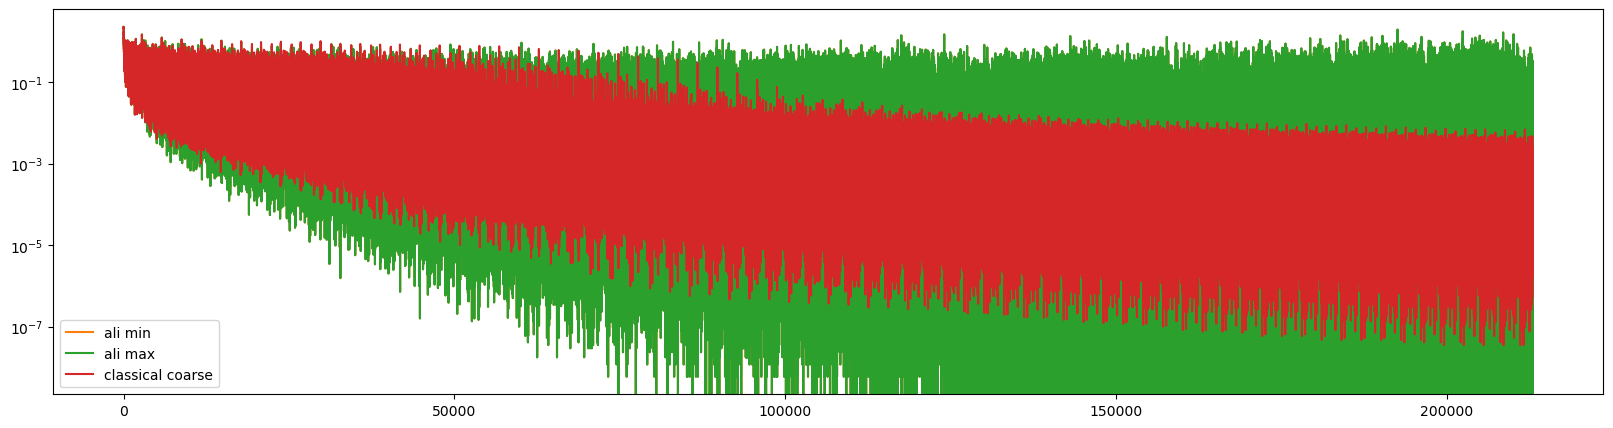

In [ ]:
plt.figure(figsize=(20,5))
if T2:
    plt.plot(np.zeros(max(len(s1),len(s2))))#,len(s3))))

if T2:
    plt.plot(s2, label='ali min')
plt.plot(s1,label='ali max')
if T3:
    plt.plot(s3, label='classical coarse')
plt.yscale('log')

plt.legend()
#plt.ylim((1e-8,1.1))
#plt.xlim((99800,102000))
plt.show()

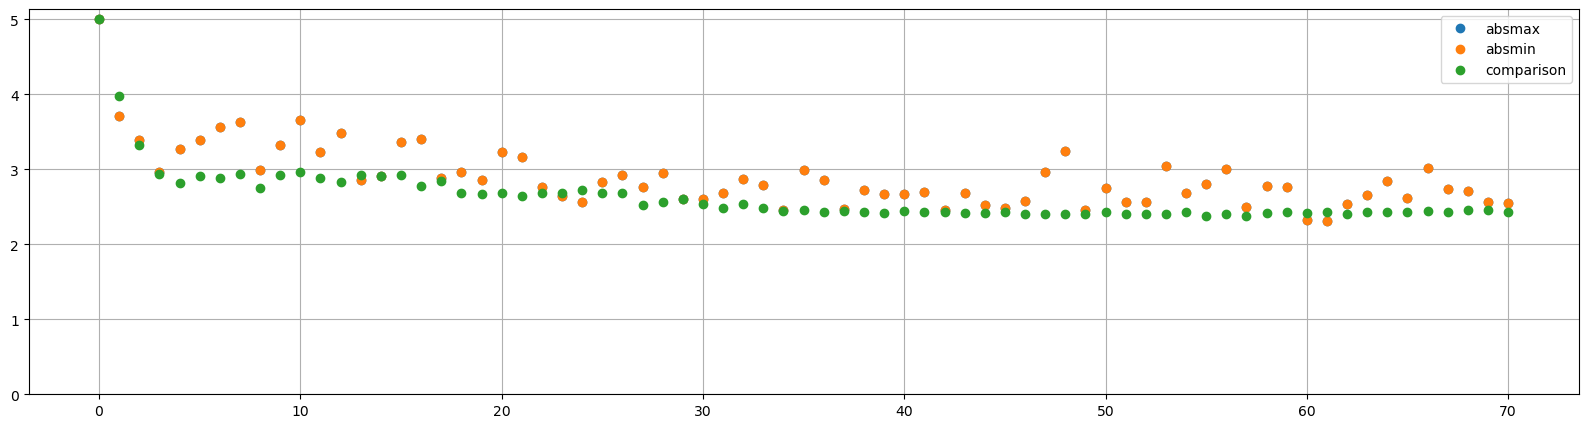

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(test_errors1,'o',label='absmax')
if T2:
    plt.plot(test_errors2,'o', label='absmin')
if T3:
    plt.plot(test_error_classical,'o',label='comparison')
plt.grid()
plt.ylim(bottom=0)
plt.legend()